## Explainable AI (XAI) with SHAP - regression problem
Practical guide for XAI analysis of SHAP for regression problem

In [1]:
import warnings
warnings.filterwarnings('ignore')
from sklearn import datasets, ensemble, model_selection
import numpy as np
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import shap
from sklearn.datasets import make_multilabel_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

Model explainability becomes a basic part of the machine learning pipeline. Keeping a machine learning model as a “black box” is not an option anymore. Luckily there are tools that are evolving rapidly and becoming more popular. This guide is a practical guide for XAI analysis of SHAP open source Python package for a regression problem.
SHAP (Shapley Additive Explanations) by Lundberg and Lee (2016) is a method to explain individual predictions, based on the game theoretically optimal Shapley values. Shapley values are a widely used approach from cooperative game theory that come with desirable properties. The feature values of a data instance act as players in a coalition. The Shapley value is the average marginal contribution of a feature value across all possible coalitions[1].
In this guide we will use the Boston house prices dataset example from sklearn datasets. It is a simple regression problem[2].

In [3]:
boston = datasets.load_boston()
X_train, X_test, y_train, y_test = model_selection.train_test_split(boston.data, boston.target, random_state=0)

After splitting the dataset to train and test, create the model and fit.

In [4]:
regressor = ensemble.RandomForestRegressor()
regressor.fit(X_train, y_train);

## Calculating Shapley value
With SHAP package the calculation is quite simple and straightforward. We only need the model (regressor) and the dataset (X_train).

In [5]:
shap.initjs()

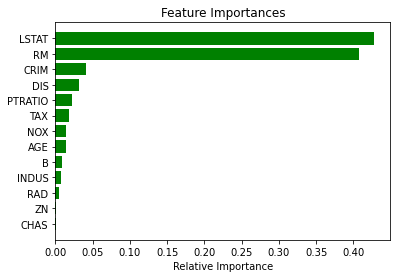

In [6]:
importances = regressor.feature_importances_
indices = np.argsort(importances)
features = boston.feature_names
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [7]:
import shap
# Create object that can calculate shap values
explainer = shap.TreeExplainer(regressor)
# Calculate Shap values
shap_values = explainer.shap_values(X_train)

After calculating the SHAP values we can plot several analyses that will help us understand the model.

## SHAP Feature importance
As a first step I recommend to view the feature importance. It is a basic insight of the model. In the following figure you can see a comparison between feature importance calculated by SHAP values (features with large absolute Shapley values are important) and feature importance computed as the mean and standard deviation of accumulation of the impurity decrease within each tree (using scikit-learn [3]). As you can see they look quite similar but they are not the same.

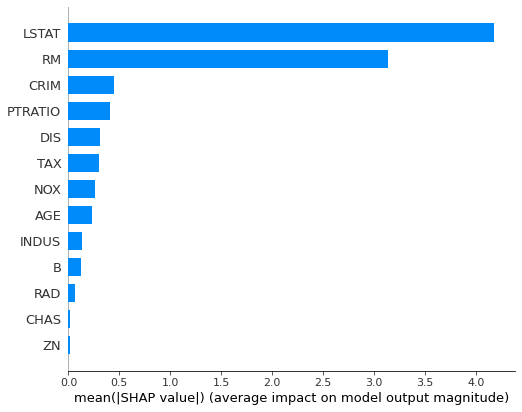

In [12]:
shap.summary_plot(shap_values, X_train, feature_names=features, plot_type="bar")

## SHAP Summary Plot
The summary plot combines feature importance with feature effects. Each point on the summary plot is a Shapley value of an instance per feature. The position on the y-axis is determined by the feature and on the x-axis by the Shapley value of each instance. You can see that the feature LSTAT is the most important feature, has high Shapley value range. The color represents the value of the feature from low to high. Overlapping points are jittered in y-axis direction, so we get a sense of the distribution of the Shapley values per feature. The features are ordered according to their importance.

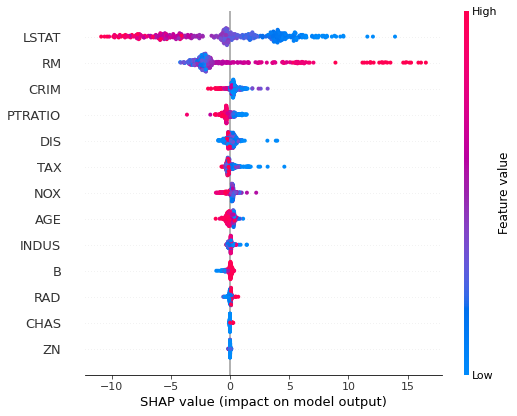

In [11]:
shap.summary_plot(shap_values, X_train, feature_names=features)

In the summary plot, we see first indications of the relationship between the value of a feature and the impact on the prediction. But to see the exact form of the relationship, we have to look at SHAP dependence plots.
## SHAP Dependence Plot
The partial dependence plot (PDP or PD plot) shows the marginal effect that one or two features have on the predicted outcome of a machine learning model (J. H. Friedman 2001 [4]). A partial dependence plot can show whether the relationship between the target and a feature is linear, monotonic or more complex. The partial dependence plot is a global method: The method considers all instances and gives a statement about the global relationship of a feature with the predicted outcome. An assumption of the PDP is that the first feature are not correlated with the second feature. If this assumption is violated, the averages calculated for the partial dependence plot will include data points that are very unlikely or even impossible.
A dependence plot is a scatter plot that shows the effect of single feature on the predictions made by the model. In this example the property value increases significantly when the average number of rooms per dwelling is higher than 6.
Each dot is a single prediction (row) from the dataset.
The x-axis is the actual value from the dataset.
The y-axis is the SHAP value for that feature, which represents how much knowing that feature value changes the output of the model for that prediction.
The color corresponds to a second feature that may have an interaction effect with the feature we are plotting (by default this second feature is chosen automatically). If an interaction effect is present between this other feature and the feature we are plotting it will show up as a distinct vertical pattern of coloring.

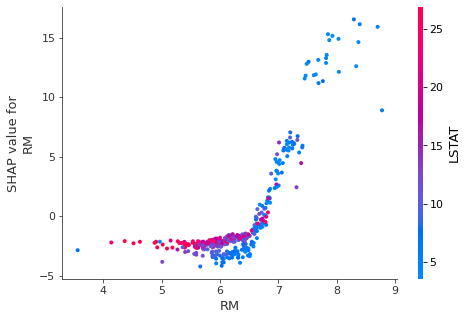

In [13]:
shap.dependence_plot(5, shap_values, X_train, feature_names=features)

In the above example we can see that average number of rooms per dwelling above 7.5 the CRIM is always low. The Shapley values of this cases are high, meninge the results greatly. This insight is a function of dependence interaction between RM, CRIM features.
## SHAP Force plot
This plot gives us the explainability of a single model prediction. Force plot can be used for 

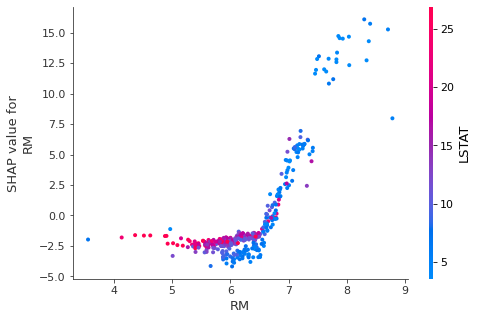

In [11]:
shap.dependence_plot(5, shap_values, X_train, feature_names=features)

In the above example we can see that average number of rooms per dwelling above 7.5 the CRIM is always low. The Shapley values of this cases are high, meninge the results greatly. This insight is a function of dependence interaction between RM, CRIM features.
## SHAP Force plot
This plot gives us the explainability of a single model prediction. Force plot can be used for error analysis, finding the explanation to specific instance prediction.

In [16]:
i = 18
shap.force_plot(explainer.expected_value, shap_values[i], X_test[i], feature_names = features)

## From the plot we can see:

1. The model output value: 16.83
2. The base value: this is the value that would be predicted if we didn’t know any features for the current instance. The base value is the average of the model output over training datatset (explainer.expected_value in the code).
3. The numbers on the plot arrows are the value of the feature for this instance. CRIM, per capita crime rate by town = 0.06664 and RM, average number of rooms = 6.546
4. Red representing features that pushed the model score higher, and blue representing features that pushed the score lower.
5. The bigger the arrow, the bigger the impact of the feature on the output. The amount of decrease or increase in the impact can be seen in the x axis.
6. CRIM of 0.066 increases the property value, RM of 6.546 reduces the property value.
If we want more global representation of the previous predictions, we can use a variant of the force plot. Here we can see the predictions for a group of rows placed vertically (rotated of 90°) and side by side. In the below figure we can see the first 5 rows in the dataset.

In [18]:
# visualize the first 5 predictions explanations with a dark red dark blue color map.
shap.force_plot(explainer.expected_value, shap_values[0:5,:], X_test[0:5,:], plot_cmap="DrDb", feature_names=features)

## SHAP Decision plot
The Decision Plot shows essentially the same information as the Force Plot. The grey vertical line is the base value and the red line indicates if each feature moved the output value to a higher or lower value than the average prediction.
This plot can be a little bit more clear and intuitive than the previous one, especially when there are many features to analyze. In the Force Plot the information may look very condensed when the number of predictors is high.

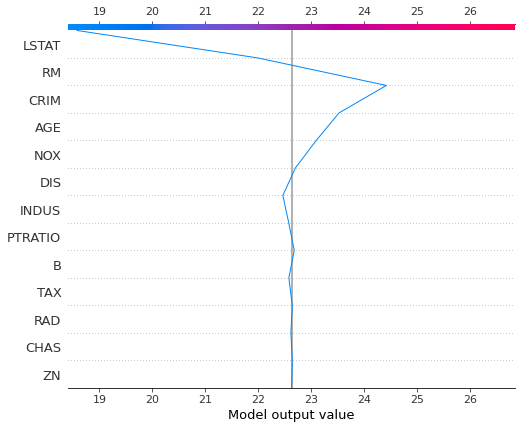

In [19]:
shap.decision_plot(explainer.expected_value[0], shap_values[0], feature_names = list(features))

The decision plot’s straight vertical line marks the model’s base value. The colored line is the prediction. Feature values are printed next to the prediction line for reference. Starting at the bottom of the plot, the prediction line shows how the SHAP values accumulate from the base value to arrive at the model’s final score at the top of the plot. Decision plots are literal representation of SHAP values, making them easy to interpret.
The force plot and the decision plot are both effective in explaining the foregoing model’s prediction. The magnitude and direction of the major effects are easy to identify.

## Summary
The SHAP framework has proved to be an important advancement in the field of machine learning model interpretation. SHAP combines several existing methods to create an intuitive, theoretically sound approach to explain predictions for any model. SHAP values quantify the magnitude and direction (positive or negative) of a feature’s effect on a prediction[6]. I believe XAI analysis with SHAP and other tools should be an integral part of the machine learning pipeline. For more about XAI for multiclass classification problem with SHAP see the link.

# Multi-class

## Glass cls

In [14]:
# define the dataset location
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/glass.csv'
# load the csv file as a data frame
df = pd.read_csv('glass.csv')
data = df.values
# split into input and output elements
X, y = data[:, :-1], data[:, -1]

In [15]:
df.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [16]:
y = df['Type'].copy()
X = df.drop(['Type'], axis=1)

In [17]:
features_names = X.columns
features_names

Index(['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe'], dtype='object')

In [18]:
X

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.00,0.0
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.00,0.0
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.00,0.0
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.00,0.0
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.00,0.0
...,...,...,...,...,...,...,...,...,...
209,1.51623,14.14,0.00,2.88,72.61,0.08,9.18,1.06,0.0
210,1.51685,14.92,0.00,1.99,73.06,0.00,8.40,1.59,0.0
211,1.52065,14.36,0.00,2.02,73.42,0.00,8.44,1.64,0.0
212,1.51651,14.38,0.00,1.94,73.61,0.00,8.48,1.57,0.0


In [19]:
y

0      1
1      1
2      1
3      1
4      1
      ..
209    7
210    7
211    7
212    7
213    7
Name: Type, Length: 214, dtype: int64

In [20]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, random_state=0)

shap.initjs()

In [21]:
cls = RandomForestClassifier(max_depth=2, random_state=0)
cls.fit(X_train, y_train);

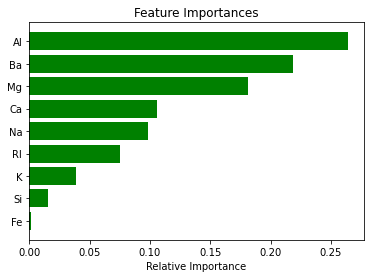

In [22]:
importances = cls.feature_importances_
indices = np.argsort(importances)
features = df.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [23]:
class_names = ['buildingwindowsfloatprocessed', 'buildingwindowsnonfloatprocessed', ' vehiclewindowsfloatprocessed', 'vehiclewindowsnonfloatprocessed', 'containers', 'tableware']

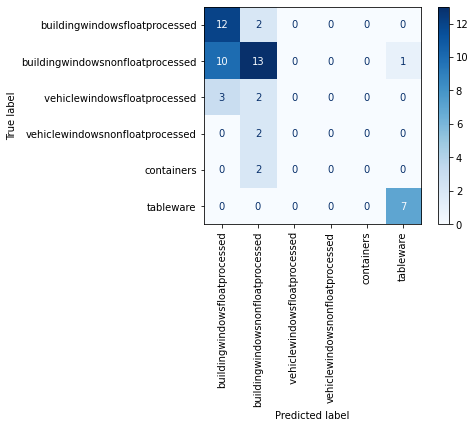

In [24]:
disp = plot_confusion_matrix(cls, X_test, y_test, display_labels=class_names, cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.show()

In [25]:
# compute SHAP values
explainer = shap.TreeExplainer(cls)
shap_values = explainer.shap_values(X)

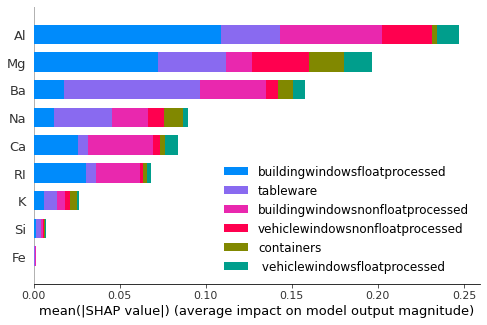

In [26]:
shap.summary_plot(shap_values, X.values, plot_type="bar", class_names= class_names, feature_names = X.columns)

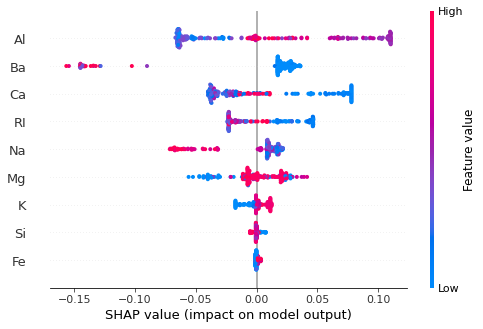

In [27]:
shap.summary_plot(shap_values[1], X.values, feature_names = X.columns)

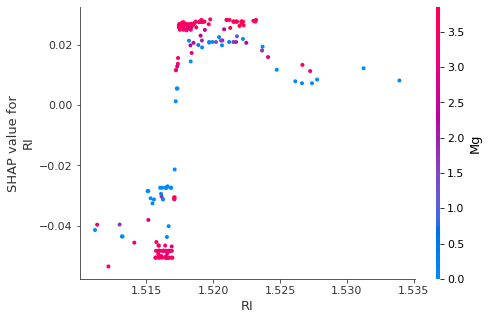

In [28]:
# If we pass a numpy array instead of a data frame then we
# need pass the feature names in separately
shap.dependence_plot(0, shap_values[0], X.values, feature_names=X.columns)

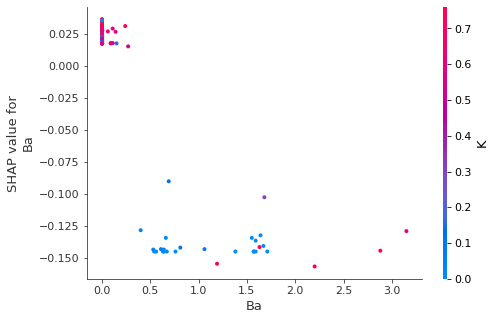

In [29]:
# make plot.+++
shap.dependence_plot("Ba", shap_values[1], X.values, feature_names=features_names, interaction_index = "K")

In [43]:
i=35
shap.force_plot(explainer.expected_value[0], shap_values[0][i], X.values[i], feature_names = X.columns)

In [45]:
from shap import Explanation
shap.waterfall_plot(Explanation(shap_values[0][i], X.values[i]))

Exception: waterfall_plot requires a scalar base_values of the model output as the first parameter, but you have passed an array as the first parameter! Try shap.waterfall_plot(explainer.base_values[0], values[0], X[0]) or for multi-output models try shap.waterfall_plot(explainer.base_values[0], values[0][0], X[0]).